In [1]:
//************************************************************************//
//                                                                        //
//  Copyright 2017 Bertram Kopf (bertram@ep1.rub.de)                      //
//                 - Ruhr-Universität Bochum                              //
//                                                                        //
//  This file is part of Pawian.                                          //
//                                                                        //
//  Pawian is free software: you can redistribute it and/or modify        //
//  it under the terms of the GNU General Public License as published by  //
//  the Free Software Foundation, either version 3 of the License, or     //
//  (at your option) any later version.                                   //
//                                                                        //
//  Pawian is distributed in the hope that it will be useful,             //
//  but WITHOUT ANY WARRANTY; without even the implied warranty of        //
//  MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the         //
//  GNU General Public License for more details.                          //
//                                                                        //
//  You should have received a copy of the GNU General Public License     //
//  along with Pawian.  If not, see <http://www.gnu.org/licenses/>.       //
//                                                                        //
//************************************************************************//

#include <iostream>
#include <sstream>
#include <fstream>
#include <cstdlib>
#include <memory>
#include <string>
#include <vector>
#include "TFile.h"
#include "TH1F.h"
#include "TH2F.h"
#include "TCanvas.h"
#include "TMath.h"
#include "TKey.h"
#include "TLegend.h"
#include "TGraphErrors.h"
#include "TLatex.h"
#include "TExec.h"

#include <algorithm> 
#include <vector>
#include <complex>

TGraph* argandGraph;
std::vector<float> massVec;

TCanvas* canvas = new TCanvas("RealS","RealS",20, 20, 900,900);
TCanvas* canvas2 = new TCanvas("Argand", "Argand", 20, 20, 900,900);

In [2]:
double getSqrT11(double eta, double phase){
  complex<double> imagNum(0.,1.);
  complex<double> etaVec2EiDelta11(cos(2.*phase*TMath::Pi()/180.), sin(2.*phase*TMath::Pi()/180.));
  etaVec2EiDelta11*=eta;
  complex<double> currentT11 = (etaVec2EiDelta11-complex<double>(1.,0.))/(2.*imagNum);
  return norm(currentT11);
}

In [3]:
double errorSqrT11(double eta, double phase, double deltaeta, double deltaphase) {
  double varFac = 1.e-8;
  double sqrtT11 = getSqrT11(eta, phase);
  double sqrtT11varEta = getSqrT11(eta + varFac, phase);
  double sqrtT11varDelta = getSqrT11(eta, phase + varFac); 
  double dT11overdEta = (sqrtT11varEta - sqrtT11) / varFac; 
  double dT11overdPhase = (sqrtT11varDelta-sqrtT11) / varFac;

  double result=sqrt(dT11overdEta * dT11overdEta * deltaeta * deltaeta
                     + dT11overdPhase * dT11overdPhase * deltaphase * deltaphase);
  return result;
}

In [4]:
void drawtext() {
  Int_t i, n;
  Double_t x, y;
  TLatex *l;
  
  n = argandGraph->GetN();
  double oldX = 100.;
  double oldY = 100.;
  for (i=1; i<n; i++) {
    argandGraph->GetPoint(i, x, y);
    double currentDist=sqrt((oldX-x) * (oldX-x) + (oldY-y) * (oldY-y));
    if( currentDist > 0.15) {
      oldX = x;
      oldY = y;    
      l = new TLatex(x, y+0.05, Form("%4.2f", massVec.at(i)));
      l->SetTextSize(0.025);
      l->SetTextFont(42);
      l->SetTextAlign(21);
      l->Paint();
    }
  }
}

In [5]:
void extractScatteringData(std::string iFileName="PiPiData.txt") {
  std::ifstream iStream(iFileName.c_str());
  if (!iStream) {
    cout << "can not open " << iFileName << endl;  // << endmsg;
    exit(1);
  }

  std::vector<float> phaseVec;
  std::vector<float> phaseErrVec;
  std::vector<float> etaVec;
  std::vector<float> etaErrVec;

  while (!iStream.eof()) {
    double m, phase, phaseErr, eta, etaError;
    iStream >> m >> phase >> phaseErr >> eta >> etaError;
    cout << "m: " << m << " phase: " << phase << " phaseErr: " << phaseErr 
         << " eta: " << eta << " etaError: " << etaError << endl;
    massVec.push_back(m);
    phaseVec.push_back(phase);
    phaseErrVec.push_back(phaseErr);
    etaVec.push_back(eta);
    etaErrVec.push_back(etaError); 
  }

  TGraphErrors* phaseGraphErr = new TGraphErrors();
  TGraphErrors* etaGraphErr = new TGraphErrors();
  TGraphErrors* T11sqrGraphErr = new TGraphErrors();
  T11sqrGraphErr->SetTitle("|T_{11}|^{2}");  
  argandGraph = new TGraph();
  argandGraph->SetTitle("Argand Diagram #pi#pi #rightarrow #pi#pi");  

  for(int i=0; i<massVec.size(); ++i) {
    phaseGraphErr->SetPoint(i, massVec.at(i), phaseVec.at(i));
    phaseGraphErr->SetPointError(i, 0., phaseErrVec.at(i));

    etaGraphErr->SetPoint(i, massVec.at(i), etaVec.at(i));
    etaGraphErr->SetPointError(i, 0., etaErrVec.at(i));

    double mag = etaVec.at(i) / 2.;
    double phi = 2.*phaseVec.at(i) * TMath::Pi()/180. - TMath::Pi()/2.;

    complex<double> thePoint = complex<double>(mag * cos(phi), mag * sin(phi) + 0.5);
    argandGraph->SetPoint(i, thePoint.real(), thePoint.imag());

    double sqrT11 = getSqrT11(etaVec.at(i), phaseVec.at(i));
    T11sqrGraphErr->SetPoint(i, massVec.at(i), sqrT11);

    double sqrT11Err = errorSqrT11(etaVec.at(i), phaseVec.at(i), etaErrVec.at(i), phaseErrVec.at(i));
    T11sqrGraphErr->SetPointError(i, 0., sqrT11Err);
  }

  canvas->Divide(2, 2);
  canvas->cd(1); 
  phaseGraphErr->Draw("ap");
  canvas->cd(2);
  etaGraphErr->Draw("ap");
  canvas->cd(3);
  argandGraph->SetMarkerStyle(7);
  TExec *ex = new TExec("ex", "drawtext();");
  argandGraph->GetListOfFunctions()->Add(ex);

  argandGraph->Draw("ALP");

  canvas->cd(4);
  T11sqrGraphErr->Draw("ap");

  canvas2->cd();
  argandGraph->Draw("ALP");  
}

m: 0.286423 phase: 2.91934 phaseErr: 0.01 eta: 1 etaError: 0.001
m: 0.290065 phase: 3.65908 phaseErr: 0.01 eta: 1 etaError: 0.001
m: 0.293707 phase: 4.32249 phaseErr: 0.01 eta: 1 etaError: 0.001
m: 0.297349 phase: 4.94241 phaseErr: 0.01 eta: 1 etaError: 0.001
m: 0.30099 phase: 5.53527 phaseErr: 0.01 eta: 1 etaError: 0.001
m: 0.304632 phase: 6.11062 phaseErr: 0.01 eta: 1 etaError: 0.001
m: 0.308274 phase: 6.67453 phaseErr: 0.01 eta: 1 etaError: 0.001
m: 0.311915 phase: 7.23112 phaseErr: 0.01 eta: 1 etaError: 0.001
m: 0.315557 phase: 7.78332 phaseErr: 0.01 eta: 1 etaError: 0.001
m: 0.319199 phase: 8.33328 phaseErr: 0.01 eta: 1 etaError: 0.001
m: 0.322841 phase: 8.88263 phaseErr: 0.01 eta: 1 etaError: 0.001
m: 0.326482 phase: 9.43263 phaseErr: 0.01 eta: 1 etaError: 0.001
m: 0.330124 phase: 9.98426 phaseErr: 0.01 eta: 1 etaError: 0.001
m: 0.333766 phase: 10.5383 phaseErr: 0.01 eta: 1 etaError: 0.001
m: 0.337408 phase: 11.0954 phaseErr: 0.01 eta: 1 etaError: 0.001
m: 0.341049 phase: 11.656 

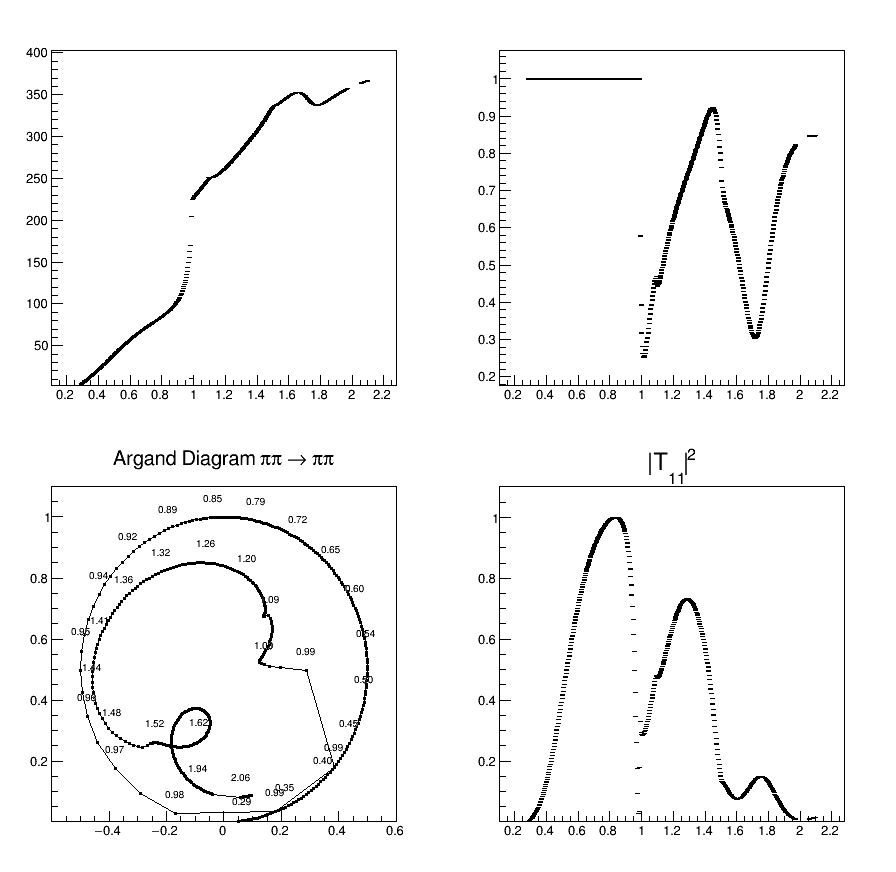

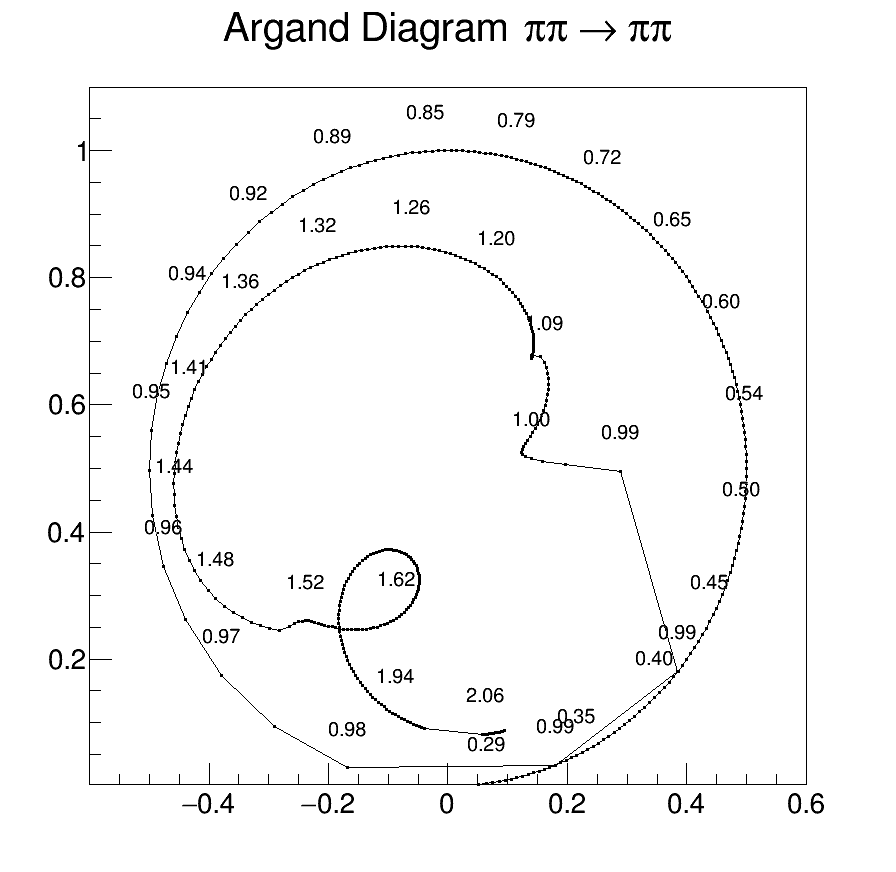

In [6]:
extractScatteringData("/data/jollyj/bertram/fits/pbarp/coupled_PiPiEta_PiEtaEta_KKPi/paperFinalHyper/final/Ochs2013---/4f2_0orderBgV5a/qaf0Matrix/scatteringOut.txt");

canvas->Draw();
canvas2->Draw();
